In [1]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 
import string

#from netCDF4 import Dataset
#from wrf import getvar
#import wrf
#from wrf import ALL_TIMES
#### 

import scipy.stats
# define plots
def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind[ind].shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5, one_to_one_line = True) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        if one_to_one_line: 
            plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=2, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p

plt.style.use('ggplot')
# read in temp data 
filepath = '../cityheat/Bmore/2016/'

meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')
# remove data before the thermometer was installed
for ind in tempDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    tempDF.loc[:start_hour,ind] = np.nan
    
rhDF = pd.read_csv(filepath + 'data/CleanedRH2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')
rhDF.columns = rhDF.columns.astype('int')
for ind in rhDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    rhDF.loc[:start_hour,ind] = np.nan
    
urban_sensor = 86 #97 # science center
rural_sensor = 4 #68 # darryn's house

# import data to classify dry days and wet days 
file =  'data/' + 'BWI'+ '.dbdmt'
synopticDF =  pd.read_table(file, sep = ' ', header =  None, parse_dates = [1])
synopticDF.columns = ['id','date', 'ssc']
synopticDF = synopticDF.set_index(synopticDF['date'])
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
syn = synopticDF['ssc']['2016-06-01': '2016-09-15'].resample('D').mean()#[pd.PeriodIndex(UHI.index, freq = 'D')[0]:pd.PeriodIndex(UHI.index, freq = 'D')[-1]]

# import asos obs
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')

for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

/Users/annascott2/anaconda2/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:84: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:91: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/annascott2/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


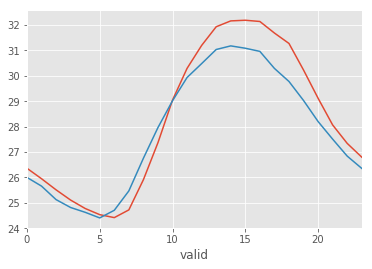

In [389]:
tempDF['2016-07-01':'2016-08-31'][97].groupby(tempDF['2016-07-01':'2016-08-31'].index.hour).mean().plot()
obs['2016-07-01':'2016-08-31']['urban'].groupby(obs['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'ASOS')

# Subtract off science center bias

In [2]:
tempDF_uncorrected = tempDF.copy()
start_date = '2016-07-01'
end_date = '2016-08-30'
bias = tempDF[97].subtract(obs['urban'])['2016-07-01':'2016-08-31']
avg_daily_bias = bias.groupby(bias.index.hour).mean()
smoothed_bias = pd.concat([avg_daily_bias, avg_daily_bias, avg_daily_bias]).rolling(3, center = True).mean().iloc[24:48]
tempDF_corrected = tempDF_uncorrected.subtract(smoothed_bias[tempDF_uncorrected.index.hour].values,axis=0)
tempDF= tempDF_corrected[start_date:end_date]#.drop(41,axis=1)
meta = meta.loc[tempDF.columns]

In [454]:
tempDF.to_csv('data/correctedibuttontemp2016.csv')

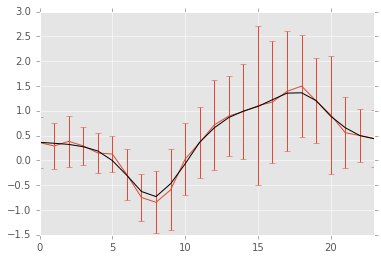

In [3]:
bias.groupby(bias.index.hour).mean().plot(yerr = bias.groupby(bias.index.hour).std())
smoothed_bias.plot(style='k')

{'boxes': [<matplotlib.lines.Line2D at 0x126834810>],
 'caps': [<matplotlib.lines.Line2D at 0x12691c790>,
 'fliers': [<matplotlib.lines.Line2D at 0x12692aa90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x12692a450>],
 'whiskers': [<matplotlib.lines.Line2D at 0x126834a10>,
  <matplotlib.lines.Line2D at 0x12691c150>]}

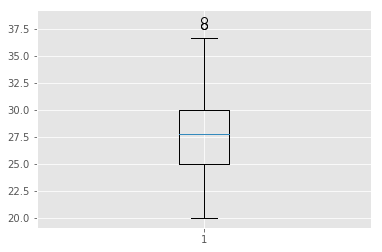

In [122]:
plt.boxplot(obs['2016-07-01':'2016-08-31']['urban'].dropna().values)

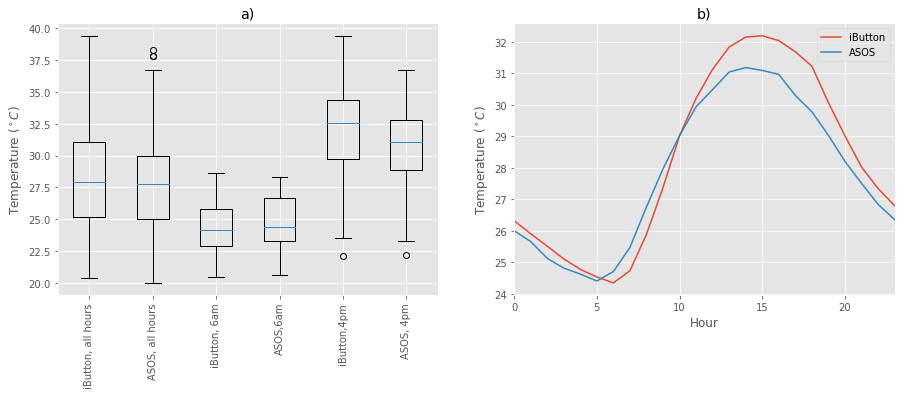

In [133]:
plt.figure(figsize = [15,5])
#plot temp
ax = plt.subplot(1,2,1)
data = [tempDF_uncorrected['2016-07-01':'2016-08-31'][97], 
        obs['2016-07-01':'2016-08-31']['urban'].dropna().values, 
        tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97],
        obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban'].dropna(), 
        tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97],
        obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban'].dropna(),         
       ]
handles = plt.boxplot(data,positions=[0,1,2,3,4,5])
labels = ['iButton, all hours', 'ASOS, all hours','iButton, 6am', 'ASOS,6am','iButton,4pm', 'ASOS, 4pm',]
x_handles = ax.set_xticklabels(labels,rotation='vertical')
ax.set_title('a)') 
ax.set_ylabel('Temperature ($^\circ C$)')
ax = plt.subplot(1,2,2)
tempDF_uncorrected['2016-07-01':'2016-08-31'][97].groupby(tempDF_uncorrected['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'iButton')
obs['2016-07-01':'2016-08-31']['urban'].groupby(obs['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'ASOS')
plt.legend()
ax.set_title('b)')
ax.set_ylabel('Temperature ($^\circ C$)')
ax.set_xlabel('Hour')
plt.savefig('figures/ibuttonbias.png')

In [4]:
tempDF_corrected = tempDF_uncorrected.subtract(smoothed_bias[tempDF_uncorrected.index.hour].values,axis=0)
tempDF= tempDF_corrected[start_date:end_date]

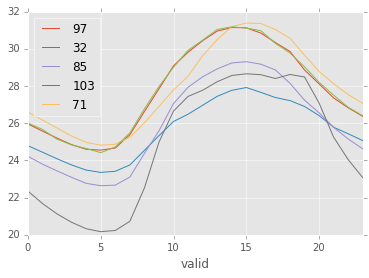

In [7]:
tempDF[selected].groupby(tempDF.index.hour).mean().plot()
obs[start_date:end_date]['urban'].groupby(obs[start_date:end_date].index.hour).mean().plot(label = 'ASOS')

In [130]:
meta.loc[103]

sensornumber                                                        103
meta:instanceID               uuid:eb0315e6-2e43-499a-b67e-7ef746b614ae
oldsensornumber                                                     103
location:Latitude                                               39.4179
location:Longitude                                             -76.6711
location:Altitude                                                    56
location:Accuracy                                                     3
direction                                                             0
sunorshade                                                      partial
attachment                                                         tree
landcoverclass                                                    grass
vesasitenumber                                                      NaN
vesacategory                                                        NaN
picture               https://bmorecoolodk.appspot.com/view/bina

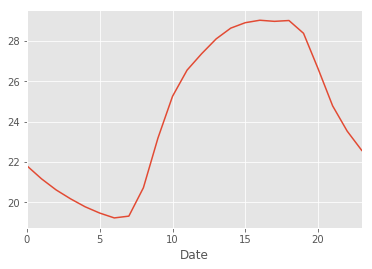

In [129]:
tempDF_uncorrected[103].groupby(tempDF_uncorrected.index.hour).mean().plot()

(0.11630205601821574, 0.55052563088353068, 1.5400366638563518e-112)

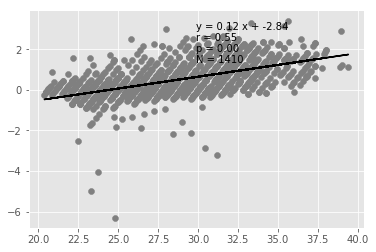

In [406]:
easy_scatter(tempDF[97][bias.index], bias)

(0.15806478608987731, 0.45339007168870243, 0.00031073465511819446)

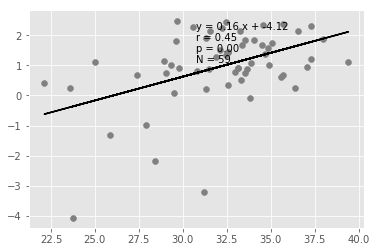

In [410]:
easy_scatter(tempDF[tempDF.index.hour==16][start_date:end_date][97], 
            bias[bias.index.hour==16][start_date:end_date])

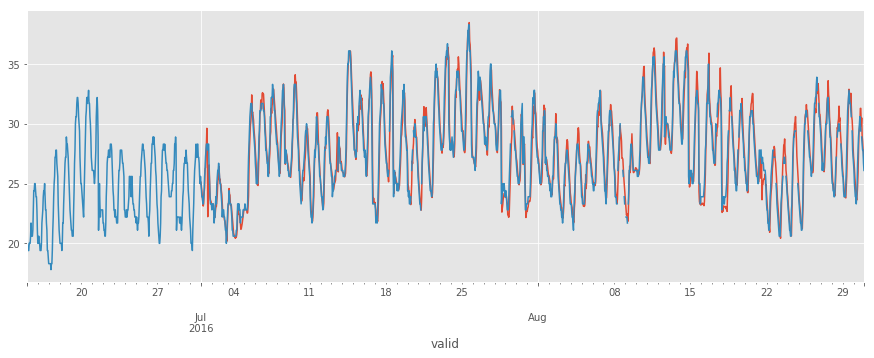

In [455]:
tempDF[97][ '2016-06-15':'2016-08-30'].plot(figsize = [15,5])
obs['urban'][ '2016-06-15':'2016-08-30'].plot()

# Map (could also be spatial variability?) 

The transition to renewables isn't "100s of years" away, it's whenever we decide that fossil fuels aren't our only option. The technology is here. http://www.baltimoresun.com/news/opinion/readersrespond/bs-ed-rr-natural-gas-letter-20180306-story.html

In [319]:
import cartopy.crs as ccrs
import matplotlib

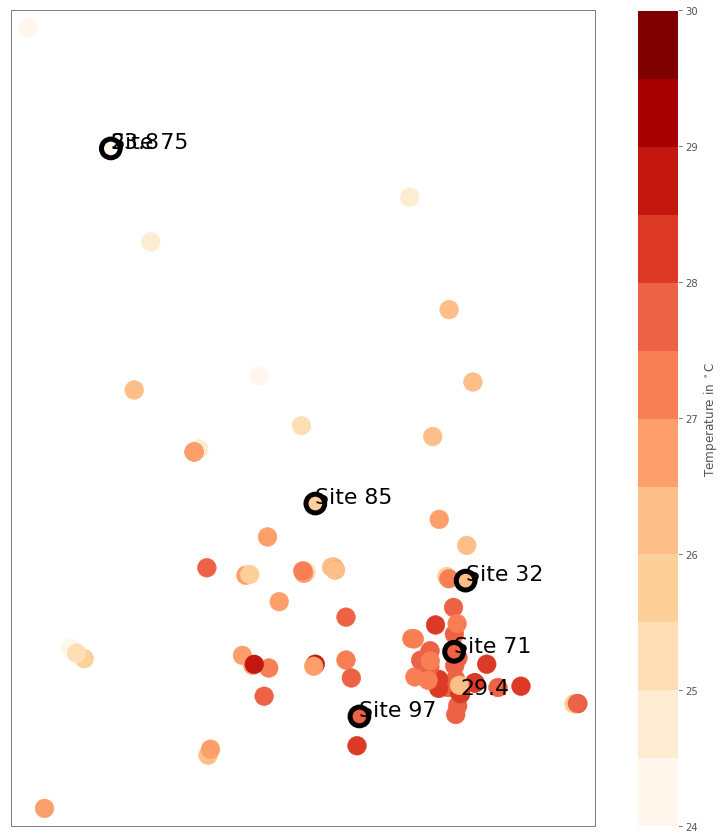

In [800]:
x = meta['location:Longitude'].values
y = meta['location:Latitude'].values
c = tempDF.mean(axis=0)
marker_size = 350
fig = plt.figure(figsize=[15,15])
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(( meta['location:Longitude'].min()-.005,
               meta['location:Longitude'].max()+.005 ,
               meta['location:Latitude'].min()-.005,
               meta['location:Latitude'].max()+.005))

cmap = matplotlib.cm.OrRd
bounds = np.linspace(round((c.mean()-3)),round((c.mean()+3)),13)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
plotHandle = ax.scatter(x,y,c = c, s = marker_size, transform=ccrs.Geodetic(),
             cmap = cmap,
             norm = norm)
ax.scatter(meta['location:Longitude'][selected].values, 
          meta['location:Latitude'][selected].values, 
          facecolor = 'None', edgecolor = 'k', s = marker_size, lw = 5,  transform=ccrs.Geodetic(),
          )
for ind in selected: 
    ax.annotate('Site %s'%ind, xy = ax.projection.transform_point(meta['location:Longitude'][ind], meta['location:Latitude'][ind],
                                           src_crs=ccrs.Geodetic()), 
                color='black', backgroundcolor='none', size=22,) 
                                                
cbar1 = plt.colorbar(plotHandle, label = 'Temperature in $^\circ $C')
lon = x[np.nanargmax(c)]
lat = y[np.nanargmax(c)]
at_x, at_y = ax.projection.transform_point(lon, lat,
                                           src_crs=ccrs.Geodetic())
plt.annotate(
    '%2.1f'%np.nanmax(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
    color='black', backgroundcolor='none', size=22,
    )

lon = x[np.nanargmin(c)]
lat = y[np.nanargmin(c)]
at_x, at_y = ax.projection.transform_point(lon, lat,
                                           src_crs=ccrs.Geodetic())
plt.annotate(
    '%2.1f'%np.nanmin(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
    color='black', size = 22, backgroundcolor='none')

In [781]:
tempDF[meta[meta.sunorshade =='partial'].index].mean().sort_values(ascending = False)

66     28.354868
86     28.151579
124    28.057461
126    27.989768
71     27.909289
100    27.856301
107    27.841053
97     27.767642
62     27.735970
99     27.729109
131    27.714604
108    27.708859
60     27.656041
70     27.646016
98     27.643371
102    27.639029
69     27.626184
77     27.557039
80     27.513708
105    27.446366
72     27.403022
88     27.277464
92     27.244929
33     27.244026
109    27.143396
91     26.830714
74     26.821461
83     26.780773
128    26.736331
12     26.650715
44     26.508571
129    26.463955
143    26.450949
123    26.382574
141    26.269552
94     26.258712
127    26.154031
73     26.120544
43     25.916858
103    24.820854
130    24.797032
dtype: float64

In [31]:
# would be helpful to have this as a plotly object

In [6]:
sci_center = 97
urbn_park = 32
north_city = 85
rural = 68
selected = [97,32,85,103, #75,#68, 
           #66, # hot but right next to sci center
            #86,
            #126,
            71,
            #100,#78, 66,86,
           ]

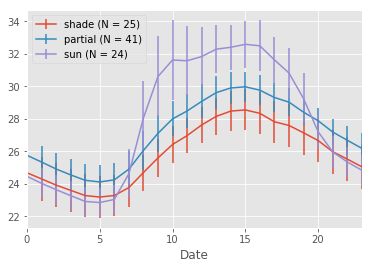

In [780]:
category = 'shade'
for category in ['shade', 'partial', 'sun']: 
    tempDF[meta[meta.sunorshade ==category].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(
        yerr = tempDF[meta[meta.sunorshade ==category].index].groupby(tempDF.index.hour).mean().std(axis=1), 
        label = '%s (N = %i)'%(category, len(meta[meta.sunorshade ==category].index)))
plt.legend()

# Diurnal cycle 

In [46]:
meta.loc[selected]

,sensornumber,meta:instanceID,oldsensornumber,location:Latitude,location:Longitude,location:Altitude,location:Accuracy,direction,sunorshade,attachment,landcoverclass,vesasitenumber,vesacategory,picture,time,shield,notes
97,97.0,uuid:a0c24290-c9d3-400f-9531-db6f35608f8f,97,39.281527,-76.611088,-27.0,4.9,0.0,partial,tree,grass,NaN,NaN,https://bmorecoolodk.appspot.com/view/binaryDa...,Tue Jun 21 15:21:13 UTC 2016,basic,nothingtoadd
32,32.0,uuid:737e87ae-8b1f-4b1b-a3f0-56bbef5b0618,32,39.320552,-76.580579,19.0,5.0,0.0,shade,tree,dirt,2.0,f,https://bmorecoolodk.appspot.com/view/binaryDa...,Fri May 06 13:37:45 UTC 2016,foil,Clifon
85,85.0,uuid:07ee92ab-bca1-4073-8451-3e5d2af5510b,85,39.342708,-76.623759,51.0,5.0,0.0,shade,tree,grass,NaN,NaN,https://bmorecoolodk.appspot.com/view/binaryDa...,Wed Jun 15 13:50:23 UTC 2016,basic,Kathy's house
103,103.0,uuid:eb0315e6-2e43-499a-b67e-7ef746b614ae,103,39.417883,-76.671059,56.0,3.0,0.0,partial,tree,grass,NaN,NaN,https://bmorecoolodk.appspot.com/view/binaryDa...,Wed Jun 22 22:26:10 UTC 2016,basic,Meadowood park behind rain garden
71,71.0,uuid:8b860b8b-aed0-4754-ac6e-16ffc10c559d,71,39.300105,-76.583898,36.3,5.8,0.0,partial,tree,impervious,NaN,NaN,https://bmorecoolodk.appspot.com/view/binaryDa...,Sun Jun 19 17:56:15 UTC 2016,basic,Medium sized cherry tree


In [883]:
selected_labels.label.values

array(['SciCenter', 'Urban Forest', 'Urban Park', 'Rural', 'Inner City'], dtype=object)

In [899]:
selected_labels

,label
97,SciCenter
32,Urban Forest
85,Urban Park
75,Rural
71,Inner City


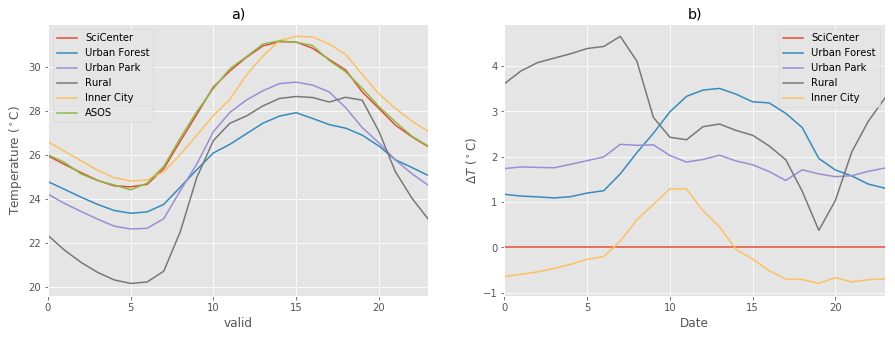

In [47]:
plt.figure(figsize = [15,5])
selected_labels = pd.DataFrame(['SciCenter', 'Urban Forest', 'Urban Park', 'Rural', 'Inner City'], columns=['label'], index = selected, )

#plot temp
ax = plt.subplot(1,2,1)
#tempDF.groupby(tempDF.index.hour).mean().plot( color = 'grey', alpha = .25, legend = False, ax =ax,zorder =1)
tempDF[selected].groupby(tempDF.index.hour).mean().plot(ax=ax,zorder =2, legend = False)
obs[start_date:end_date]['urban'].groupby(obs[start_date:end_date].index.hour).mean().plot(ax=ax, label = 'ASOS',zorder =2)
ax.set_title('a)')
ax.set_ylabel('Temperature ($^\circ$C)')
plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))

# plot DT
ax = plt.subplot(1,2,2)
(tempDF*-1).add(tempDF[97], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax, legend = False)
ax.set_title('b)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')

plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
plt.savefig('figures/diurnal.png')

# UHI intensity as a function of distance from the city center
# Variability within city

http://connor-johnson.com/2014/03/20/simple-kriging-in-python/


The semi-variance provides a measure of spatial variance as a function of distance; it indicates an average difference between two data points $f(a), f(a+h)$ given their distance apart $h$: 
$$ s(h) = \frac{1}{2 N(h)} \sum _{N(h)} \left(f(a+h) -f(a)\right)^2 $$
Here, we calculate the experimental semi-variance by making $h$ a discrete variable equal to fixed-width distances. 

In [2]:
locations.shape

NameError: name 'locations' is not defined

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars


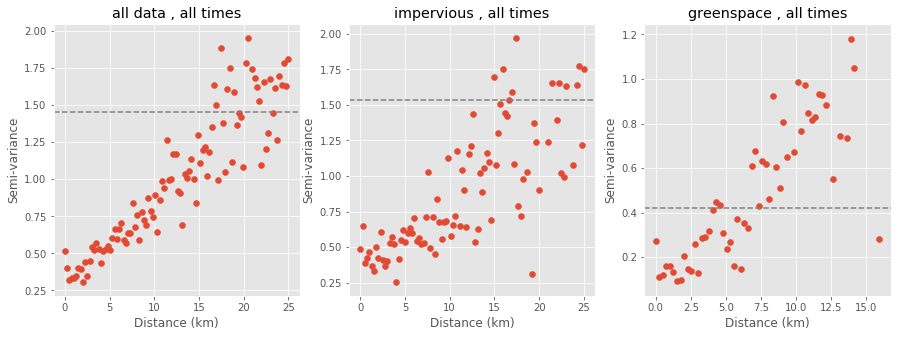

In [482]:
r_earth = 6371
locations0 = np.array([meta['location:Longitude'].dropna(), meta['location:Latitude'].dropna()]).T
data0 = tempDF.mean()[meta['location:Longitude'].dropna().index].values

locations1 = np.array([meta['location:Longitude'][meta['landcoverclass']=='grass'].dropna(), 
                      meta['location:Latitude'][meta['landcoverclass']=='grass'].dropna()]).T
data1 = tempDF.mean()[meta['location:Longitude'][meta['landcoverclass']=='grass'].dropna().index].values

locations2 = np.array([meta['location:Longitude'][meta['landcoverclass']=='impervious'].dropna(), 
                      meta['location:Latitude'][meta['landcoverclass']=='impervious'].dropna()]).T
data2 = tempDF.mean()[meta['location:Longitude'][meta['landcoverclass']=='impervious'].dropna().index].values

squared_difference = np.zeros([N,N])
distances = np.zeros([N,N])
#hs = np.linspace(0,.25, 50)/360*2*np.pi*r_earth
hs = np.linspace(0,25,100)
bandwidth = np.abs(hs[1]-hs[0])
fig =plt.figure(figsize=[15,5])
iii = 1
for data,locations,label in zip([data0,data1,data2], [locations0,locations1,locations2], ['all data', 'impervious', 'greenspace']):
    N = data.shape[0]
    ax = plt.subplot(1,3,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
    #            if (distance[i,j] >= h-bandwidth) and (distance[i,j]< h+bandwidth)
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram)
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s , all times'%label)
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    iii = iii+1

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in double_scalars


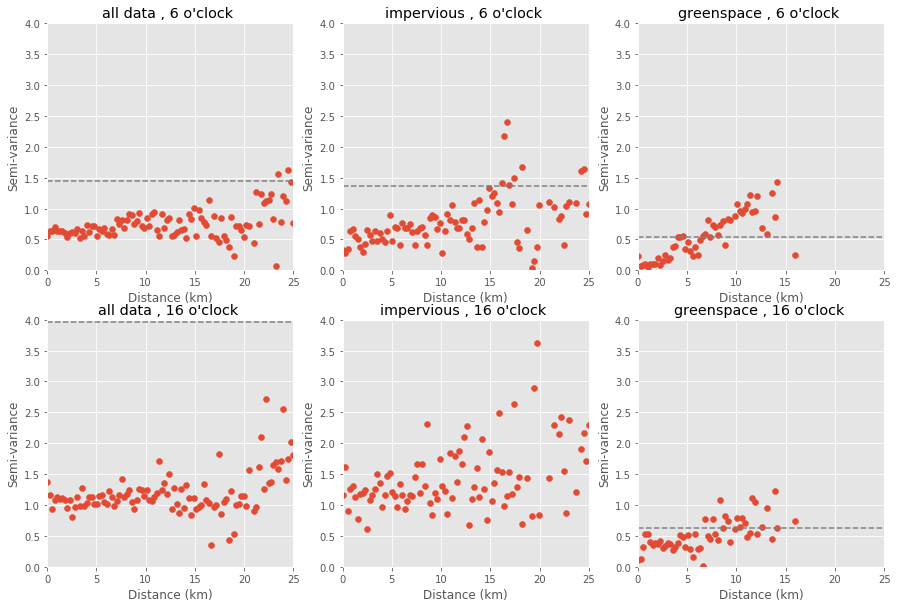

In [41]:
fig =plt.figure(figsize=[15,10])
iii = 1
r_earth = 6371
for hr in [6,16]: 
    locations0 = np.array([meta['location:Longitude'].dropna(), meta['location:Latitude'].dropna()]).T
    data0 = tempDF[tempDF.index.hour ==hr].mean()[meta['location:Longitude'].dropna().index].values
    data0 = data0[~np.isnan(data0)]
    
    locations1 = np.array([meta['location:Longitude'][meta['landcoverclass']=='grass'].dropna(), 
                          meta['location:Latitude'][meta['landcoverclass']=='grass'].dropna()]).T
    data1 = tempDF[tempDF.index.hour ==hr].mean()[meta['location:Longitude'][meta['landcoverclass']=='grass'].dropna().index].values
    data1 = data1[~np.isnan(data1)]
    
    locations2 = np.array([meta['location:Longitude'][meta['landcoverclass']=='impervious'].dropna(), 
                          meta['location:Latitude'][meta['landcoverclass']=='impervious'].dropna()]).T
    data2 = tempDF[tempDF.index.hour ==hr].mean()[meta['location:Longitude'][meta['landcoverclass']=='impervious'].dropna().index].values
    data2 = data2[~np.isnan(data2)]

#     squared_difference = np.zeros([N,N])
#     distances = np.zeros([N,N])
    #hs = np.linspace(0,.25, 50)/360*2*np.pi*r_earth
    hs = np.linspace(0,25,100)
    bandwidth = np.abs(hs[1]-hs[0])

    for data,locations,label in zip([data0,data1,data2], [locations0,locations1,locations2], ['all data', 'impervious', 'greenspace']):
        N = data.shape[0]
        ax = plt.subplot(2,3,iii)
        semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
        for h in hs:
            Z = []
            for i in range(N): 
                for j in range(i+1,N): 
                    #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                    distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                    if (distance >= h) and (distance< h+bandwidth):
        #            if (distance[i,j] >= h-bandwidth) and (distance[i,j]< h+bandwidth)
                        Z.append(np.abs(data[i] - data[j])) 
            semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
        ax.scatter(semivariogram.index, semivariogram.semivariogram)
        ax.axhline(data.var(), linestyle ='--', color = 'gray')
        ax.set_title('%s , %i o\'clock '%(label,hr))
        ax.set_xlabel('Distance (km)')
        ax.set_ylabel('Semi-variance')
        ax.set_ylim([0,4])
        ax.set_xlim([0,25])
        iii = iii+1
plt.savefig('figures/spatialvariability.png')

In [43]:
data1.var()

5.1121867447437728

In [497]:
data0.var()

3.9573588574934084

In [499]:
data0.std()

1.989311151502803

In [ ]:
# to do: label variance lines, possibly label data w/in 1km?, standardize axis limits

We next examine how different locations vary from one aonther. Figure Xa shows a semi-variogram: the semi-variance (in units of variance or $^\circ C^2$ )is plotted against distance for all locations at 6am. For sites within one kilometer of one another, the semi-variance is less than $0.5$, which translates to temperature differences of $0.7^\circ$C on average. As distance between sites increases, the semi-variance increases linearly, indicating that farther away points are more and more dissimilar.  While the semi-variance is noisier at longer distances, this is due to having fewer datapoints at certain distances. This may be why the semi-variogram is exceeds its theoretical limit of the sample variance for some of the distances between 15-25 kilometers. Overall, we see that sites closer together are more similar and farther sites are more dissimilar.  

It is possible that variability in the land type drives temperature variability. In Figure Xb, we look at sites dominated by impervious landcover at 6am and see that the variogram follows a similar pattern to that of Fig.~Xa: closer sites are similar and farther sites are dissimilar. At distances beyond 15km, the semi-variances remain close to the variance of X.  This is in contrast with the semi-variogram for green landcovers at 6am (Fig.Xc). Though  overall green sites have lower variance, the semi-variance increases with distance without evidence of a limit.

In the afternoon, variability is higher for variograms of all sites, impervious sites, and green sites at 6pm (Fig.Xd,e,f). The variance for all data, $3.9^\circ C$ (Fig.Xd), translates into an average temperature difference of 1.98$^\circ $ degrees, much higher than that at 6am. Impervious spaces remain dissimilar for the range of distances examined (Fig.~Xe). Greenspaces grow dissimilar at a constant rate, but remain less variable than impervious spaces.

This suggests that: 
- average temperature difference across sites is several degrees at most
- spatial variability lower at 6 am than at 4pm (PUT NUMBERS HERE)
- green spaces more variable than non-green spaces 
This implies that temperature variability within the urban heat island is lower than suggested by satellite land surface temperature products. 
Futhermore, as semi-variograms fit to are used in Kreiging spatial estimation technique this suggests that the simple Kreiging model would accurately model temperature data in an urban setting. 

# Variability by landcover type

We need to know: how does temp vary with landcover type

In [31]:
data = [ tempDF.values.flatten()[~np.isnan(tempDF.values.flatten())], #tempDF[tempDF.index.hour==hr].values.flatten(),
        tempDF[tempDF.index.hour==hr][meta[meta['landcoverclass']=='impervious'].index].dropna().values.flatten(),
            tempDF[tempDF.index.hour==hr][meta[meta['landcoverclass']=='grass'].index].dropna().values.flatten(),
           ]

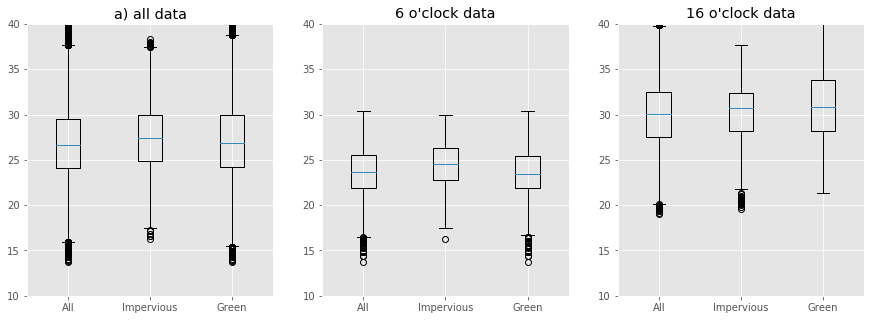

In [44]:
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,3,1)
# data = [tempDF.mean().dropna().values.flatten(),
#     tempDF.mean()[meta[meta['landcoverclass']=='impervious'].index].dropna().values.flatten(),
#         tempDF.mean()[meta[meta['landcoverclass']=='grass'].index].dropna().values.flatten(),
#        ]
data = [tempDF.values.flatten()[~np.isnan(tempDF.values.flatten())],#tempDF.values.flatten(),
    tempDF[meta[meta['landcoverclass']=='impervious'].index].dropna().values.flatten(),
        tempDF[meta[meta['landcoverclass']=='grass'].index].dropna().values.flatten(),
       ]
handles = plt.boxplot(data,positions=[0,1,2])
labels = ax.set_xticklabels(['All', 'Impervious', 'Green'])
ax.set_title('a) all data')
ax.set_ylim([10,40])
#ax.set_ylim([20,40])
iii = 2
for hr in [6,16]: 
    ax = plt.subplot(1,3,iii)
    data = [ tempDF[tempDF.index.hour==hr].values.flatten()[~np.isnan(tempDF[tempDF.index.hour==hr].values.flatten())], #tempDF[tempDF.index.hour==hr].values.flatten(),
        tempDF[tempDF.index.hour==hr][meta[meta['landcoverclass']=='impervious'].index].dropna().values.flatten(),
            tempDF[tempDF.index.hour==hr][meta[meta['landcoverclass']=='grass'].index].dropna().values.flatten(),
           ]
#         data = [tempDF[tempDF.index.hour==hr].mean().dropna().values.flatten(),
#         tempDF[tempDF.index.hour==hr][meta[meta['landcoverclass']=='impervious'].index].mean().dropna().values.flatten(),
#             tempDF[tempDF.index.hour==hr][meta[meta['landcoverclass']=='grass'].index].mean().dropna().values.flatten(),
#            ]
    handles = plt.boxplot(data,positions=[0,1,2])
    labels = ax.set_xticklabels(['All', 'Impervious', 'Green'])
    ax.set_title('%s o\'clock data'%hr)
    #ax.set_ylim([20,40])
    ax.set_ylim([10,40])
    iii =iii+1
plt.savefig('figures/landcover_boxplots.png')

Our observations indicate that variability in vegetation is an important factor in determining spatial variability of 2 meter temperature. 
Observations in green sites are significantly cooler than impervious sites. This is particularly true at 6 am, when $\overline{T}_{green} = $ and $\overline{T}_{imp} = $.
However, green sites are more variable: $\sigma_{green} = $ whereas $\sigma_{imp} = $. This indicates that using green infrastructure as a heat mitigation strategy may vary in both timing and effectiveness. 

In [619]:
# import ee
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ee.Initialize()

satellitedf = pd.DataFrame(index = meta.index, columns = ['lcc', 'ndvi'])

nlcd = ee.Image('USGS/NLCD/NLCD2011').select('landcover')
Landsat8Raw = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT').filterDate('2016-06-01','2016-08-15')#.sort('CLOUD_COVER').first()

for ind in meta['location:Latitude'].dropna().index: 
        # create a EE geomtetry object of the lat/lon of the urban weather station
    point = ee.Geometry.Point([meta.loc[ind,'location:Longitude'], meta.loc[ind,'location:Latitude']])
    # sample the data of the NLCD at this location
    lcc = nlcd.sample(point,30).getInfo()

    #compute ndvi 
    l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT').filterBounds(point).filterDate('2016-06-01','2016-08-15').sort('CLOUD_COVER').first()
    ndvi = ee.Image(test).normalizedDifference(['B5', 'B4'])

    try: 
        lcc_value = data['features'][0]['properties']['landcover']
        ndvi_value = ndvi.sample(point,30).getInfo()['features'][0]['properties']['nd']
    except IndexError: 
        lcc_value = np.nan
        ndvi_value = np.nan
    satellitedf.loc[ind, 'lcc'] = lcc_value
    satellitedf.loc[ind, 'ndvi'] = ndvi_value
satellitedf.to_csv('data/satellite_values.csv')

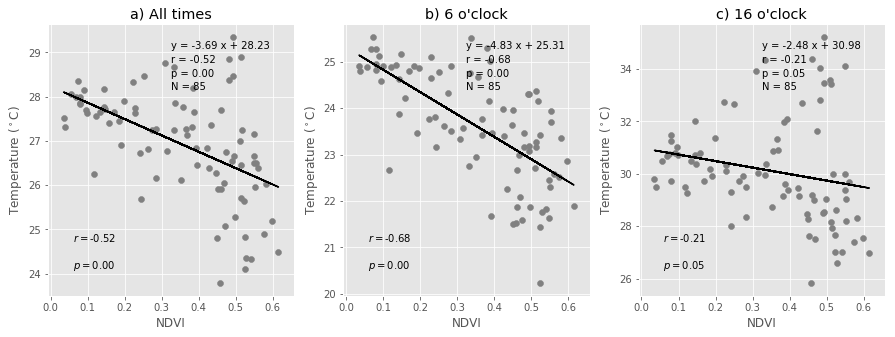

In [897]:
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,3,1)
easy_scatter(satellitedf['ndvi'].astype(float), tempDF.mean())
r,p = scipy.stats.pearsonr(tempDF.mean()[satellitedf['ndvi'].dropna().index].values,satellitedf['ndvi'].dropna().values)
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('a) All times')
iii = 2
for hr in [6,16]: 
    ax = plt.subplot(1,3,iii)
    x = satellitedf['ndvi'].astype(float).dropna()
    y = tempDF[tempDF.index.hour== hr].mean()
    y = y[x.index]
    easy_scatter(x,y)
    #ax.scatter(x,y)
    r, p = scipy.stats.pearsonr(x,y)
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('NDVI')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s) %s o\'clock'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
plt.savefig('figures/landcover.png')

In [ ]:
# regression 
import statsmodels.formula.api as sm
inPark = {'grass': 1, 'impervious': 0, 'dirt':1, 'grass impervious':0, 'grass impervious dirt': 0 }
parkyesno = np.array([inPark[x] for x in meta.loc[selected].landcoverclass])
df['InPark'] = parkyesno

result = sm.ols(formula="AirTemp ~ Elevation + C(InPark)", data=df).fit()
print(result.params)
print(result.summary())

Green infrastructure is one commonly cited means to combat urban heating (cite EPA toolkit). There are many types of green infrastructure, in Baltimore, parks, fields, and forested areas are common. We find that 
observations in green sites are significantly cooler than impervious sites. This is particularly true at 6 am, when $\overline{T}_{green} = $ and $\overline{T}_{imp} = $.
However, green sites are more variable: $\sigma_{green} = $ whereas $\sigma_{imp} = $. This indicates that using green infrastructure as a heat mitigation strategy may vary in both timing and effectiveness. 

Because there is no common index for assessing green infrastructure, we turn to satellite-measured NDVI, a proxy for photosynthetic activity that can indicate the presence of vegetation. Our observations indicate that variability in NDVI is an important factor in determining spatial variability of 2 meter temperature. 
There is also a relationship between temperature and satellite NDVI measurements, a proxy for surface vegetation. In Fig. X, NDVI is plotted against temperature for a) all times, showing a negative relationship between vegetation and temperature. The relationship is stronger for 6 am temperature (r = -0.68, Fig.~Xb) than in the afternoon (r = -0.21, Fig.~Xc). 

Questions: 

# Change during warmer periods
Heatwave mitigation is a top priority for cities, so it's important to understand what happens to city temperature in cities. 

In [703]:
def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5, one_to_one_line = False) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        if one_to_one_line: 
            plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=2, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p

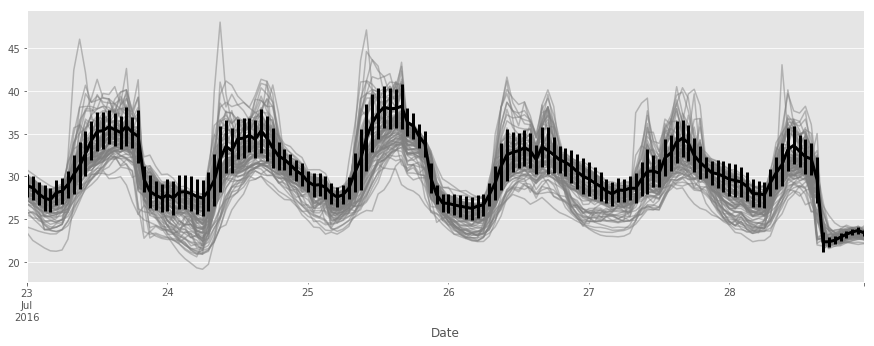

In [682]:
tempDF['2016-07-23':'2016-07-28'].plot(figsize = [15,5],legend = False, color = 'grey', alpha = .5,zorder =1)
tempDF['2016-07-23':'2016-07-28'][97].plot(yerr = tempDF['2016-07-23':'2016-07-28'].std(axis=1), 
                                           linewidth = 3, color = 'k', zorder = 2)

(0.12858554149385426,
 -2.0744603570219287,
 0.66999669430090159,
 7.7250576629717202e-116)

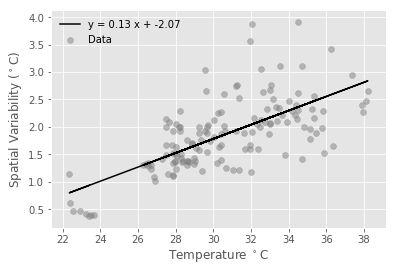

In [696]:
easy_scatter_tls(tempDF['2016-07-23':'2016-07-28'][97],tempDF['2016-07-23':'2016-07-28'].std(axis=1), 
                 '', 'Temperature $^\circ $C', 'Spatial Variability ($^\circ $C)',one_to_one_line=False)

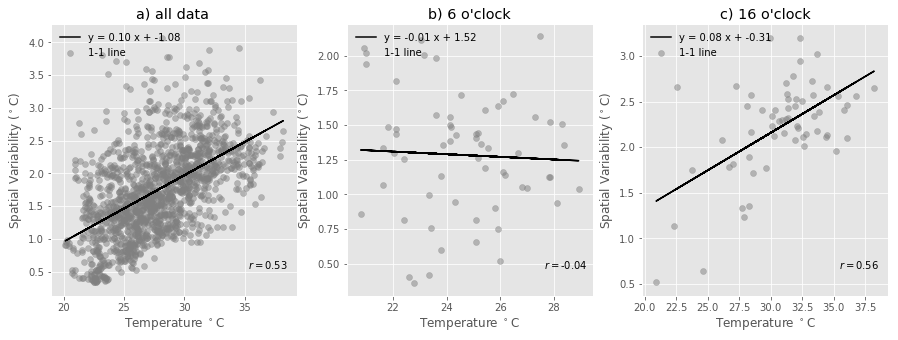

In [704]:
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,3,1)
b0,b1, r,p = easy_scatter_tls(tempDF[97],tempDF.std(axis=1), 
                 'a) all data ', 'Temperature $^\circ $C', 'Spatial Variability ($^\circ $C)',one_to_one_line=False)
ax.annotate('$r=$%2.2f'%r, xy=(.8, .1), xycoords ='axes fraction')
iii = 2 
for hr in [6,16]: 
    ax = plt.subplot(1,3,iii)
    b0,b1, r,p = easy_scatter_tls(tempDF[tempDF.index.hour==hr][97],
                     tempDF[tempDF.index.hour==hr].std(axis=1), 
                 '%s) %s o\'clock'%(string.ascii_lowercase[iii-1], hr), 'Temperature $^\circ $C', 'Spatial Variability ($^\circ $C)',one_to_one_line=False)
    ax.annotate('$r=$%2.2f'%r, xy=(.8, .1), xycoords ='axes fraction')
    iii = iii+1

In [708]:
len(selected[1:])

3

In [827]:
selected_labels.loc[ind, 'label']

'Inner City'

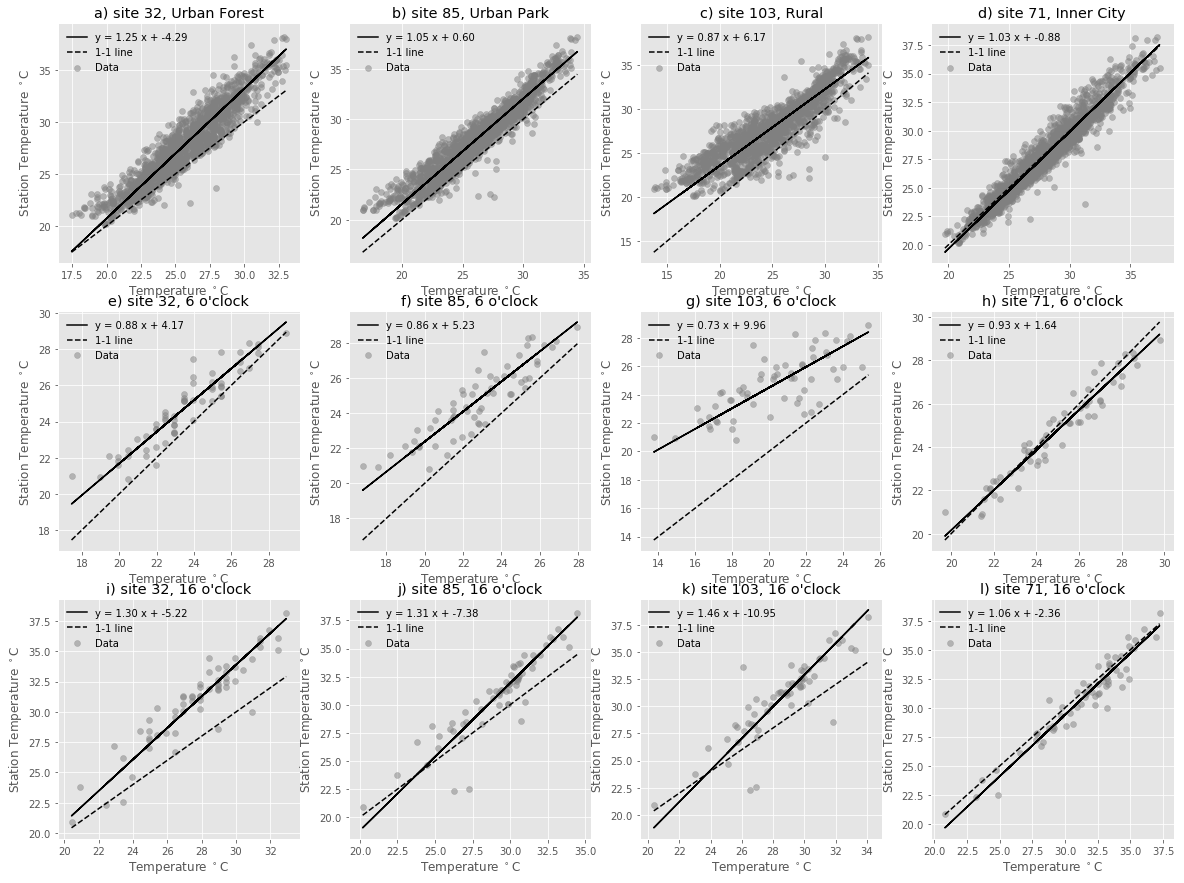

In [48]:
selected_labels = pd.DataFrame(['SciCenter', 'Urban Forest', 'Urban Park', 'Rural', 'Inner City'], columns=['label'], index = selected, )
fig = plt.figure(figsize=[5*(len(selected)-1),15])
iii = 1
for ind in selected[1:]: 
    ax = plt.subplot(3,len(selected)-1,iii) 
    b0,b1, r,p = easy_scatter_tls(tempDF[ind], tempDF[97], 
                 '%s) site %i, %s'%(string.ascii_lowercase[iii-1], ind, selected_labels.loc[ind, 'label']), 'Temperature $^\circ $C',' Station Temperature $^\circ $C',one_to_one_line=True)
    iii = iii+1

for hr in [6,16]: 
    for ind in selected[1:]: 
        ax = plt.subplot(3,len(selected)-1,iii) 
        b0,b1, r,p = easy_scatter_tls(tempDF[tempDF.index.hour==hr][ind], tempDF[tempDF.index.hour==hr][97], 
                     '%s) site %i, %s o\'clock'%(string.ascii_lowercase[iii-1],ind,hr),
                                      'Temperature $^\circ $C','Station Temperature $^\circ $C',one_to_one_line=True)
        iii = iii+1
plt.savefig('figures/heat.png')

In [9]:
pwd

u'/Users/annascott2/git/finalthesischapter'

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in double_scalars


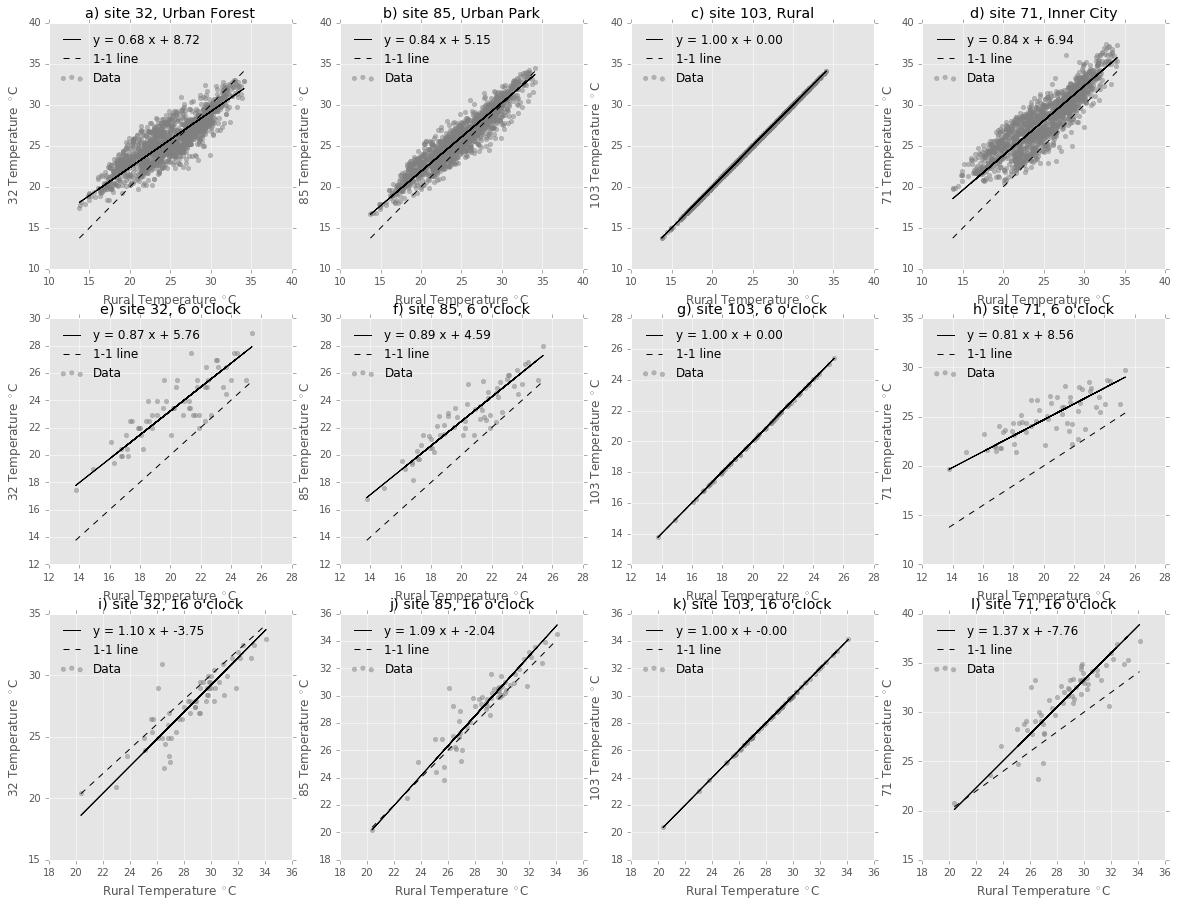

In [14]:
selected_labels = pd.DataFrame(['SciCenter', 'Urban Forest', 'Urban Park', 'Rural', 'Inner City'], columns=['label'], index = selected, )
fig = plt.figure(figsize=[5*(len(selected)-1),15])
iii = 1
for ind in selected[1:]: 
    ax = plt.subplot(3,len(selected)-1,iii) 
    b0,b1, r,p = easy_scatter_tls(tempDF[103], tempDF[ind], 
                 '%s) site %i, %s'%(string.ascii_lowercase[iii-1], ind, selected_labels.loc[ind, 'label']), 'Rural Temperature $^\circ $C',' %i Temperature $^\circ $C'%ind,one_to_one_line=True)
    iii = iii+1

for hr in [6,16]: 
    for ind in selected[1:]: 
        ax = plt.subplot(3,len(selected)-1,iii) 
        b0,b1, r,p = easy_scatter_tls(tempDF[tempDF.index.hour==hr][103], tempDF[tempDF.index.hour==hr][ind], 
                     '%s) site %i, %s o\'clock'%(string.ascii_lowercase[iii-1],ind,hr),
                                      'Rural Temperature $^\circ $C','%i Temperature $^\circ $C'%ind,one_to_one_line=True)
        iii = iii+1
plt.savefig('figures/heat.png')

In [53]:
x

Date
2016-07-01 00:00:00    24.694452
2016-07-01 01:00:00    24.338753
2016-07-01 02:00:00    23.986097
2016-07-01 03:00:00    23.533027
2016-07-01 04:00:00    23.242591
2016-07-01 05:00:00    23.061436
2016-07-01 06:00:00    23.610735
2016-07-01 07:00:00    24.998018
2016-07-01 08:00:00    25.725185
2016-07-01 09:00:00    27.403974
2016-07-01 10:00:00    27.377762
2016-07-01 11:00:00    28.439957
2016-07-01 12:00:00    28.900398
2016-07-01 13:00:00    30.066110
2016-07-01 14:00:00    28.625173
2016-07-01 15:00:00    22.220259
2016-07-01 16:00:00    22.521937
2016-07-01 17:00:00    25.077220
2016-07-01 18:00:00    25.882800
2016-07-01 19:00:00    24.604480
2016-07-01 20:00:00    23.167382
2016-07-01 21:00:00    22.900229
2016-07-01 22:00:00    22.932222
2016-07-01 23:00:00    22.811425
2016-07-02 00:00:00    22.756452
2016-07-02 01:00:00    22.587753
2016-07-02 02:00:00    22.798097
2016-07-02 03:00:00    22.970027
2016-07-02 04:00:00    22.930591
2016-07-02 05:00:00    22.311436
     

In [77]:
tempDF.iloc[:,12]

Date
2016-07-01 00:00:00    24.168452
2016-07-01 01:00:00    23.937753
2016-07-01 02:00:00    23.773097
2016-07-01 03:00:00    23.257027
2016-07-01 04:00:00    22.842591
2016-07-01 05:00:00    22.786436
2016-07-01 06:00:00    23.022735
2016-07-01 07:00:00    24.410018
2016-07-01 08:00:00    24.825185
2016-07-01 09:00:00    26.441974
2016-07-01 10:00:00    26.477762
2016-07-01 11:00:00    26.977957
2016-07-01 12:00:00    27.376398
2016-07-01 13:00:00    27.730110
2016-07-01 14:00:00    27.788173
2016-07-01 15:00:00    23.508259
2016-07-01 16:00:00    23.683937
2016-07-01 17:00:00    25.365220
2016-07-01 18:00:00    24.919800
2016-07-01 19:00:00    24.703480
2016-07-01 20:00:00    23.766382
2016-07-01 21:00:00    23.249229
2016-07-01 22:00:00    22.907222
2016-07-01 23:00:00    22.723425
2016-07-02 00:00:00    22.480452
2016-07-02 01:00:00    22.187753
2016-07-02 02:00:00    21.835097
2016-07-02 03:00:00    21.694027
2016-07-02 04:00:00    21.466591
2016-07-02 05:00:00    21.160436
     

In [83]:
betas = np.ones([tempDF.shape[1],tempDF.shape[1]])*-1#*np.nan # preallocate matrix of slopes
ms = np.ones([tempDF.shape[1],tempDF.shape[1]])*-1#*np.nan # preallocate matrix of slopes

i = 0
#for ind in tempDF.columns:
for i in range(tempDF.shape[1]): 
    x = tempDF.iloc[:,i]
    for j in range(i+1, tempDF.shape[1]):
        y = tempDF.iloc[:,j]
        ind = ~np.isnan(y) & ~np.isnan(x)
        if ind.sum() >0 : 
            mydata = Data(x[ind], y[ind])
            linear = Model(f)
            linreg = scipy.stats.linregress(x[ind], y[ind])
            myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
            myoutput = myodr.run()
            # plot it  
            betas[i,j] = myoutput.beta[0]
            ms[i,j] = myoutput.beta[1]

In [106]:
for i in range(tempDF.shape[1]): 
    for j in range(i+1, tempDF.shape[1]):
        betas[j,i] = betas[i,j]

In [107]:
betadf = pd.DataFrame(betas, index = tempDF.columns, columns=tempDF.columns, )

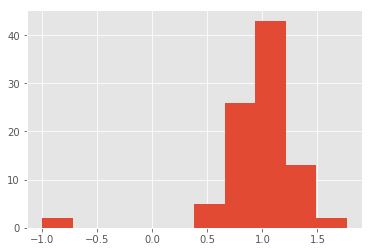

In [108]:
betadf[97].hist()

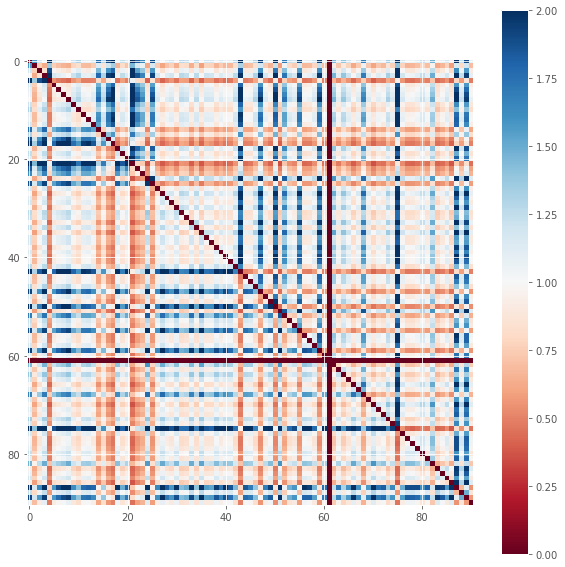

In [109]:
plt.figure(figsize = [10,10])
plt.imshow(betas, vmin = 0, vmax = 2.0, cmap = plt.cm.RdBu)
plt.colorbar()

In [ ]:
# to do: highlight hw days, compute slope m between central station and each ibutton site, also compute beta_zero, whether they're hotter or colder